In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from tabulate import tabulate
from random import random
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import roc_auc_score,precision_recall_curve,auc,roc_curve
import pickle

In [2]:
import warnings 

warnings.filterwarnings("ignore") 

In [5]:
# Load data

train_path = 'dataset/Kaggle_Training_Dataset_v2.csv'
test_path = 'dataset/Kaggle_Test_Dataset_v2.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

In [6]:
train_data.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

In [4]:
# Preprocessing as per EDA

# Dropping last row which is invalid data
# Median encoding lead_time
# Adding sales and forecast columns
# Remove sku column
# Perform OHE on categorical data
# Perfrom MinmaxScaler transform 

train_data.drop(train_data.tail(1).index,inplace=True)

lead_time_median = train_data['lead_time'].median()
train_data['lead_time'].fillna(lead_time_median,inplace=True)
   
train_data['forecast']=(train_data['forecast_3_month']>0)|(train_data['forecast_6_month']>0)|(train_data['forecast_9_month']>0)
train_data['forecast']=train_data['forecast'].astype(int)
train_data['sales']=(train_data['sales_1_month']>0)|(train_data['sales_3_month']>0)|(train_data['sales_6_month']>0)|(train_data['sales_9_month']>0)
train_data['sales']=train_data['sales'].astype(int)

remove_cols = ['sku']

train_data = train_data.drop(labels=remove_cols,axis=1)
train_data= pd.get_dummies(train_data,drop_first=True)
scaler = MinMaxScaler()
train_data_norm = scaler.fit_transform(train_data)
train_data = pd.DataFrame(train_data_norm,columns=train_data.columns)

In [5]:
# Performing the same set of transformations on test data

test_data.drop(test_data.tail(1).index,inplace=True)

test_data['lead_time'].fillna(lead_time_median,inplace=True)
test_data['forecast']=(test_data['forecast_3_month']>0)|(test_data['forecast_6_month']>0)|(test_data['forecast_9_month']>0)
test_data['forecast']=test_data['forecast'].astype(int)
test_data['sales']=(test_data['sales_1_month']>0)|(test_data['sales_3_month']>0)|(test_data['sales_6_month']>0)|(test_data['sales_9_month']>0)
test_data['sales']=test_data['sales'].astype(int)

test_data = test_data.drop(labels=remove_cols,axis=1)
test_data= pd.get_dummies(test_data,drop_first=True)

# https://stackoverflow.com/questions/41335718/keep-same-dummy-variable-in-training-and-testing-data
# Ensuring same set of columns for train and test
delta_cols = set(train_data.columns) - set(test_data.columns)

for c in delta_cols:
    test_data[c] = 0

test_data = test_data[train_data.columns]
test_data_norm = scaler.transform(test_data)
test_data = pd.DataFrame(test_data_norm,columns=test_data.columns)


In [6]:
# Separating X and target

train_x = train_data.iloc[:,:-1]
train_y = train_data.iloc[:,-1]
test_x = test_data.iloc[:,:-1]
test_y = test_data.iloc[:,-1]

In [7]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_y, predict_y):
    """
    Function to plot the confusion, precision and recall matrices
    """
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [8]:
# 1. Separate 20% of val data
# 2. Of the remaining 80%, perfrom undersampling with ratio 0.2 and then perform SMOTE oversampling
# 3. Divide this smote data into 2 equal parts d1 and d2

x_train, x_val, y_train, y_val = train_test_split(train_x, train_y,test_size=0.2,stratify=train_y)
train_x_rus, train_y_rus = RandomUnderSampler(0.2).fit_resample(x_train,y_train)
smote_x, smote_y = SMOTE().fit_resample(train_x_rus, train_y_rus)
x_d1, x_d2, y_d1, y_d2 = train_test_split(smote_x, smote_y,test_size=0.5,stratify=smote_y)


In [9]:
# Convert numpy arrays into dataframes

x_d1 = pd.DataFrame(x_d1,columns=train_x_rus.columns)
x_d2 = pd.DataFrame(x_d2,columns=train_x_rus.columns)


In [10]:
# Checking shape

x_d1.shape

(45170, 23)

In [11]:
def return_ensemble_model(x_d1,x_d2,y_d1,y_d2,k,models):
    """
    1. Creates k sample sets with replacment from x_d1,y_d1
    2. Trains a model for each sample set
    3. The output probabilities of k models predicted for x_d2 with their corresponding y_d2 are trained 
    on an ensemble model
    4. The trained models and ensemble model are returned which can be used for predictions on test set 
    """
    trained_models = []
    ensemble_x = pd.DataFrame()
    for i in range(k):
        m = models[i%len(models)] #Select model from our list of 4 models sequentially
        x,_,y,_ = train_test_split(x_d1,y_d1,test_size=0.2,stratify=y_d1) #
        m.fit(x,y)
        trained_models.append(m)
        pred = m.predict_proba(x_d2)[:,1]
        pred = pd.DataFrame(pred,columns=[str(i)])
        ensemble_x = pd.concat([ensemble_x,pred],axis=1)
    ensemble_model = LogisticRegression().fit(ensemble_x,y_d2)
    return trained_models,ensemble_model
             

In [12]:
def display_results(trained_models, ensemble_model,test_x,test_y):
    """
    From test_x, create new data with each columns being a prediction from each of trained_models
    Make predictions using ensemble_model on the new data and plot matrices and print F1 score
    """
    ensemble_x = pd.DataFrame()
    for i,m in enumerate(trained_models):
        pred = m.predict_proba(test_x)[:,1]
        pred = pd.DataFrame(pred,columns=[str(i)])
        ensemble_x = pd.concat([ensemble_x,pred],axis=1)
    predict_y = ensemble_model.predict(ensemble_x)
    plot_confusion_matrix(test_y, predict_y)
    print("F1 Score:",f1_score(test_y,predict_y))

In [18]:
# Selecting the models from our findings in CS_1_model-FE notebook with their
# respective GridSearchCV best_params_

models = [XGBClassifier(eta=0.3,max_depth=10,eval_metric='aucpr'),
         RandomForestClassifier(max_features=12,n_estimators=10),
         DecisionTreeClassifier(max_depth=10),
         LogisticRegression(C=10)]

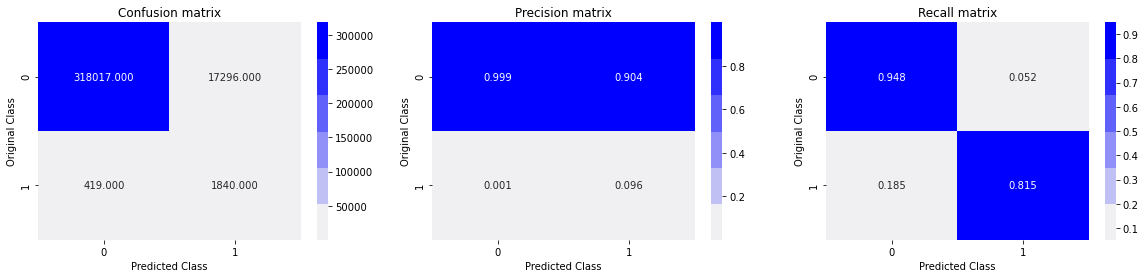

F1 Score: 0.17200280439354992


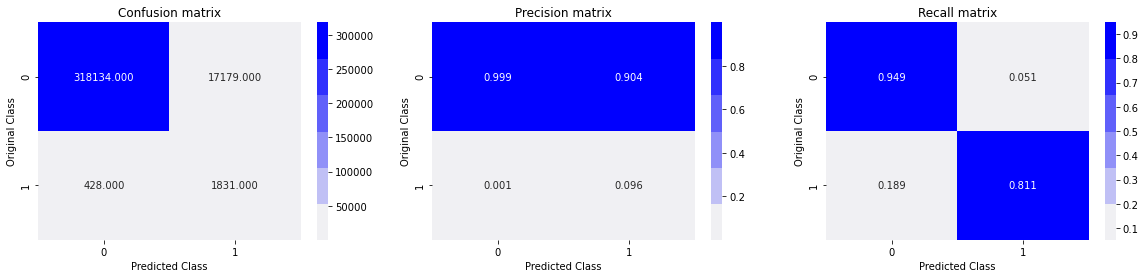

F1 Score: 0.17217546664159106


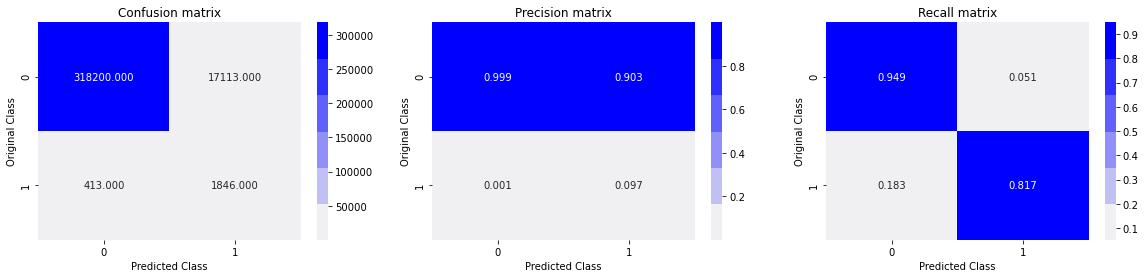

F1 Score: 0.17400320482609105


In [14]:
# Tuning our ensemble model with k as the hyper paramter

k_list = [5,15,50]
for k in k_list:
    trained_models, ensemble_model = return_ensemble_model(x_d1,x_d2,y_d1,y_d2,k,models)
    display_results(trained_models, ensemble_model,x_val,y_val)

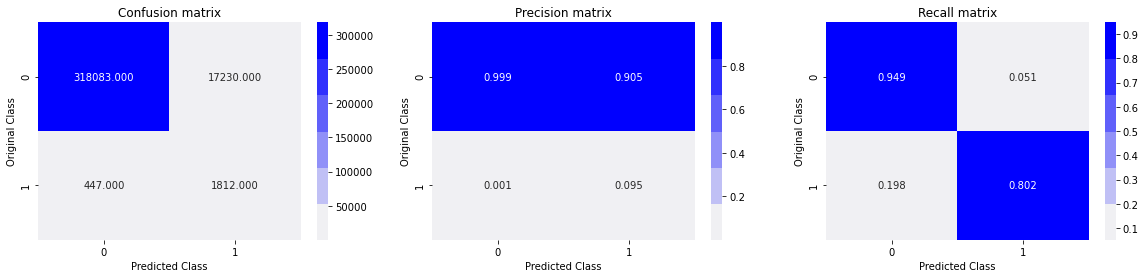

F1 Score: 0.17013285761231867


In [19]:
# Training our final model with optimal k value

trained_models, ensemble_model = return_ensemble_model(x_d1,x_d2,y_d1,y_d2,50,models)
display_results(trained_models, ensemble_model,x_val,y_val)

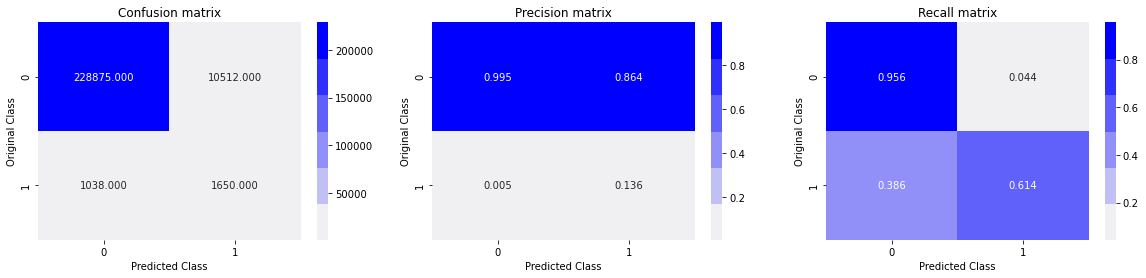

F1 Score: 0.2222222222222222


In [20]:
display_results(trained_models, ensemble_model,test_x,test_y)

In [21]:
# Storing data for preprocessing future unkown test data

for_test = {}
for_test['lead_time_median'] = lead_time_median
for_test['train_columns'] = train_data.columns
for_test['scaler'] = scaler
for_test['trained_models'] = trained_models
for_test['ensemble_model'] = ensemble_model
with open(r"for_test.pickle", "wb") as output_file:
    pickle.dump(for_test, output_file)